In [10]:
import sys        
sys.path.append('/home/huyentn2/project/nano_count/segmentation_unet/')
# from dataset.data import load_image
# import dataset as dat
from dataset import *
from utils import *

import torch.nn.functional  as F

from scipy import ndimage as ndi
from skimage.feature import peak_local_max


import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
# import wandb
import logging
import wandb
import argparse
import pdb
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--seed', type = int, dest='seed', default=10)
# parser.add_argument('--classes', type = int, dest='classes', default=2)
# parser.add_argument('--epochs', type = int, dest='epochs', default=15)
# parser.add_argument('--batch_size', type = int, dest='batch_size', default=6)
# parser.add_argument('--learning_rate', type = float,  dest='learning_rate', default=1e-5)
# parser.add_argument('--scale', type = float,  dest='scale', default=1.0)
# parser.add_argument('--val', type = float,  dest='val', default=10.0)
# parser.add_argument('--amp',  dest='amp', action='store_true')
# parser.add_argument('--bilinear',  dest='bilinear', action='store_true')
# parser.add_argument('--use_gauss', dest='use_gauss', action='store_true')
# parser.add_argument('--kfold', dest='train_fold', action='store_true')
# parser.add_argument('--num_fold', type = int, dest='num_fold', default=10)
# parser.add_argument('--eval', dest='eval', action='store_true')

# args = parser.parse_args()

In [2]:
args = {}

args['seed'] = 10
args['classes'] =2
args['epochs'] =15
args['batch_size'] = 6
args['learning_rate'] =1e-5
args['scale'] =1.0
args['val'] =10.0
args['amp'] = False
args['bilinear'] = False
args['use_gauss'] = False
args['kfold'] = False
args['num_fold'] =10
args['eval'] = True

In [3]:
def preprocess(pil_img, scale):
    w, h = pil_img.size
    newW, newH = int(scale * w), int(scale * h)
    assert newW > 0 and newH > 0, 'Scale is too small, resized images would have no pixel'
    pil_img = pil_img.resize((newW, newH))
    # pil_img = pil_img.resize((newW, newH), resample=Image.NEAREST if is_mask else Image.BICUBIC)
    img = np.asarray(pil_img)

    if img.ndim == 2:
        img = img[np.newaxis, ...]   #  img = (24,24)   -> img = (1,24,24)   append new dim at the beginning
    else:
        img = img.transpose((2, 0, 1))
    if (img > 1).any():
        img = img / 255.0

    return torch.as_tensor(img.copy()).float().contiguous()

In [4]:
# set random seed
torch.manual_seed(args['seed'])
torch.cuda.manual_seed(args['seed'])
np.random.seed(args['seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(n_channels=1, n_classes= args['classes'], bilinear=  args['bilinear'])
model = model.to(memory_format=torch.channels_last)
model = torch.nn.DataParallel(model).cuda()


checkpoint = torch.load("/home/huyentn2/project/nano_count/segmentation_unet/checkpoints_7_4/fold9/checkpoint_epoch15.pth")

model.load_state_dict(checkpoint)
model.to(device=device)



DataParallel(
  (module): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, 

In [5]:
input_dir = "/home/huyentn2/project/nano_count/segmentation_unet/data/img_patch/Tianle1ng_0208_3.png"
save_single_dir = "/home/huyentn2/project/nano_count/segmentation_unet"

mask_pred = eval_single_count(input_dir, save_single_dir, model, device, args['scale'])

/home/huyentn2/.conda/envs/nano/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


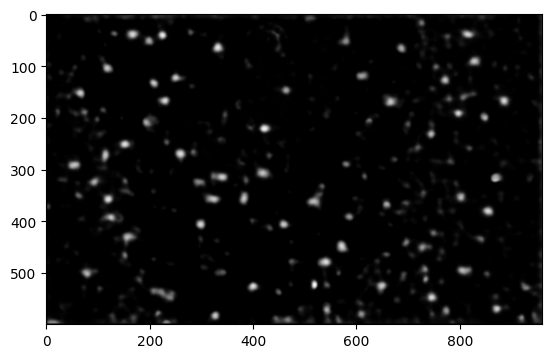

In [8]:
mask_pred_1 = F.sigmoid(mask_pred).squeeze()[1,:].float()
plt.imshow(mask_pred_1, cmap = 'gray')

In [26]:
# Image.open(input_dir)

In [20]:
min_dist = 10
thr = 100

<bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7f4c1d1c6f20>>
Num of peaks 61


Text(0.5, 1.0, 'Peak local max')

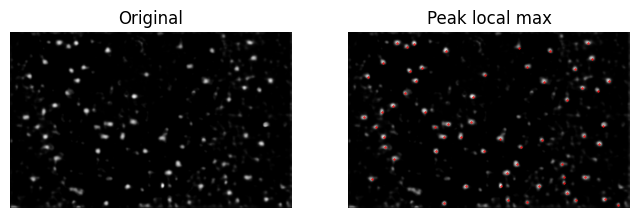

In [23]:
im = mask_pred_1.numpy()*255

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(im, size=5, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=min_dist, threshold_abs=thr)

print(input)
print("Num of peaks", len(coordinates))

# # display results
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

# ax[1].imshow(image_max, cmap=plt.cm.gray)
# ax[1].axis('off')
# ax[1].set_title('Maximum filter')

ax[1].imshow(im, cmap=plt.cm.gray)
ax[1].autoscale(False)
# ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[1].scatter(coordinates[:, 1], coordinates[:, 0], s = 0.1, c = 'r')
ax[1].axis('off')
ax[1].set_title('Peak local max')


Text(0.5, 1.0, 'Peak local max')

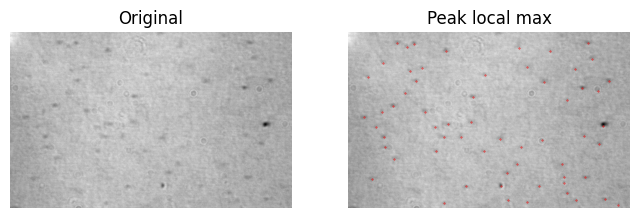

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(np.array(Image.open(input_dir)), cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')


ax[1].imshow(np.array(Image.open(input_dir)), cmap=plt.cm.gray)
ax[1].scatter(coordinates[:, 1], coordinates[:, 0], s = 0.1, c = 'r')
ax[1].axis('off')
ax[1].set_title('Peak local max')

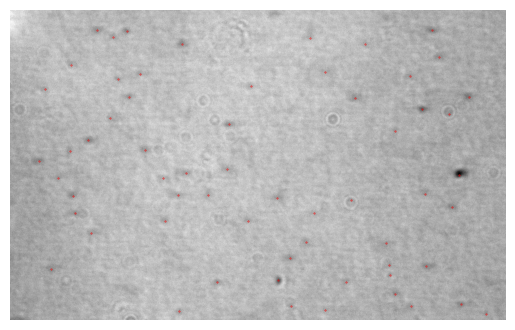

In [39]:
fig1 = plt.figure(1)

plt.imshow(np.array(Image.open(input_dir)), cmap=plt.cm.gray)
plt.scatter(coordinates[:, 1], coordinates[:, 0], s = 0.1, c = 'r')
plt.axis('off')
# plt.set_title('Peak local max')

save_dir = "/home/huyentn2/project/nano_count/segmentation_unet/"
name = input_dir.split("/")[-1]

fig1.savefig(save_dir + "pred_" + name ,bbox_inches='tight',dpi=300)